In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x))

In [78]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)

In [8]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        actions = [[env.find_words_matching_current_history]]
        actions.append([env.find_words_matching_current_history, env.find_words_with_highest_freq_score])
        actions.append([env.find_words_matching_current_history, env.find_words_with_most_new_letters])
        actions.append([env.find_words_matching_current_history, env.find_words_with_most_new_letters, env.find_words_with_highest_freq_score])
        actions.append([env.find_words_with_most_new_letters, env.find_words_with_highest_freq_score])
        actions.append([env.find_words_with_most_new_letters])
        
        self.actions = actions.copy()
        for a in actions:
                self.actions.append([env.find_target_words] + a)
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [9]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [148]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    transitions = memory.sample(batch_size)

    state_batch = torch.stack([tr.state for tr in transitions])
    action_batch = torch.stack([tr.action for tr in transitions])
    reward_batch = torch.tensor([tr.reward for tr in transitions], device=device)
       
    # calculate gradient
    probs = model(state_batch)
    sampler = Categorical(probs)
    print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action_batch)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
    
    pseudo_loss = torch.sum(log_probs * reward_batch) # loss that when differentiated with autograd gives the gradient of J(θ)
    print(f'Glog {(log_probs * reward_batch).shape}')
    print(f'pseudo loss {pseudo_loss} {pseudo_loss.__class__}')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()
    
    print(list(model.parameters()))
    
    return pseudo_loss

def optimize_model_single(model, optimizer, state, action, reward):
        
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    print(f'Glog {(log_probs * reward).shape}')
    print(f'pseudo loss {pseudo_loss} {pseudo_loss.__class__}')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [149]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128)):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action shape {action_idx.__class__} {action.shape} {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for tr in episode_memory:
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    #memory.push(tr[0], tr[1], episode_reward)
                    episode_reward -= tr[2]
                    loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    losses.append(loss)
                
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                #if len(memory) >= training.batch_size \
                #    and steps_done - last_training > training.train_interval:
                #    loss = optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                #    losses.append(loss)
                #    if training.clear_memory: memory.clear()
                #    last_training = steps_done
                
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 0 11 quota-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 1 1 tress-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 11 glyph-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 3 11 widen-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 11 mucky-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 5 1 tweet-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 7 finished.  reward -5.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 34  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.8446204662322998 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.7928895950317383 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([

------guess 3 9 shelf-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 4 9 spell-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 14 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 65  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.08133138716220856 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 15 spade======================
------guess 0 1 esses-------
reward -1.0 done False action shape 

------guess 2 9 mince-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 niece-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 23 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 102  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 24 think======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 until-------
reward -1.0 done False action shape <class 'torch.T

reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 mound-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 cough-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 4 9 couch-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 31 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 139  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.576279254957626e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog

------guess 2 9 doing-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 41 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 174  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 42 razor======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 ratio-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 rayon-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 razor-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]

------guess 1 9 lurid-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 flirt-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 twirl-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 49 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 210  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 50 rough======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.T

------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 thorn-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 flour-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 floor-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 59 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 249  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 60 bil

------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 moist-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 68 finished.  reward -1.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 286  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 69 trial======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 trial-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 69 finished.  reward -1.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 288  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.S

------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 trail-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 grand-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 79 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 322  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 80 sleek======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 islet-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size(

------guess 3 9 shorn-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 4 9 sworn-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 88 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 355  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.576279254957626e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 89 usage======================
------guess 0 9 arose-------
reward -1.0 done False action sha

reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 suite-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 snipe-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 98 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 388  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 99 botch======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
----

------guess 1 9 tidal-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 gland-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 bland-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 109 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 428  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 110 erupt======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch

------guess 2 9 timid-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 118 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 460  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 119 vegan======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 leant-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 pecan-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 began-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Siz

Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 127 enemy======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 inlet-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 enemy-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 127 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 497  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 128 gloom======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch

------guess 3 9 habit-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 136 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 530  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 137 scion======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 solid-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 scion-------
reward 0.0 done True action shape <class 'torch.T

------guess 1 9 tidal-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 vital-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 147 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 565  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 148 kneel======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 inlet-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 kneel-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size(

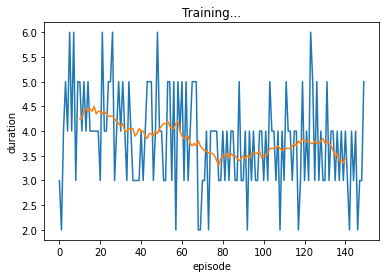

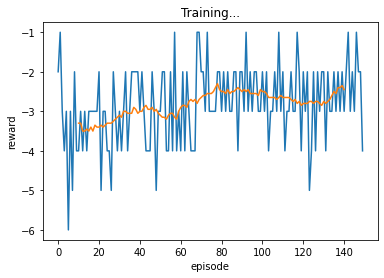

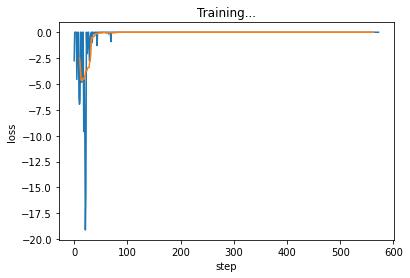

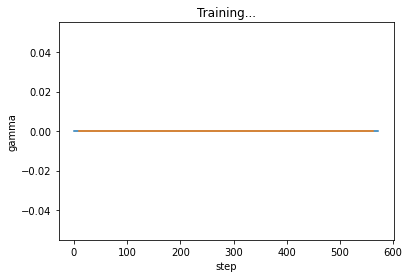

In [151]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(train_interval=64, batch_size=64, clear_memory=True, lr=1)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 2 9 haunt-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 11 pygmy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 3 vaunt-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 5 9 jaunt-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 6 finished.  reward -5.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 35  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -6.451786994934082 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.1322100162506104 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.594604015350342 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.6383321285247803 <class 'torch.Tensor'>
sampler Categoric

------guess 2 5 jumpy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 3 7 onion-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 15 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 73  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.8536853790283203 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.3876521587371826 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 16 hyper======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 4 until-------
reward -1.0 done False action shape <class 'torch.Tensor'> t

------guess 1 3 oater-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 0 crine-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 3 7 merge-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 7
------guess 4 3 perve-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 5 7 verve-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 25 finished.  reward -5.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 112  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -17.573823928833008 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.854222297668457 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.514171123504639 <class 'torch.Tensor'>
sampler Categorical(probs: torch

------guess 2 9 flail-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 llama-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 33 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 145  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.0617570877075195 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.7425962090492249 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 34 adorn======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 6 acorn-------
reward -1.0 done False action shape <class 'torch.Tensor'> 

------guess 4 9 haste-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 41 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 179  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.3810245394706726 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.048454284667969 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.6319255232810974 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 42 shack======================
------guess 0 8 datum-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 0 apeak-------
reward -1.0 done False action shape <class 't

------guess 4 9 maybe-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 5 8 payee-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 48 finished.  reward -5.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 214  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -14.541413307189941 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.8970409631729126 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.2007434368133545 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.625361680984497 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
==================

------guess 4 8 musky-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 56 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 247  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.03998885303735733 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -8.245707511901855 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.3417820930480957 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 57 plied======================
------guess 0 8 surge-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 0 foley-------
reward -1.0 done False action shape <class '

------guess 2 8 badge-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 8 nudge-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 66 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 286  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.015104322694242 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.09493977576494217 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 67 salve======================
------guess 0 8 grace-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 8 baste-------
reward -1.0 done False action shape <class 'torch.Tensor'> 

------guess 2 8 gumbo-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 76 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 319  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.008248578757047653 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 77 polka======================
------guess 0 8 regal-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 8 plank-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 2 8 polka-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 77 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 322  memory 0
sampler Categori

------guess 3 8 nadir-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 4 8 drain-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 85 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 353  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.02902105078101158 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.6065166592597961 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0069506363943219185 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 86 expel======================
------guess 0 8 louse-------
reward -1.0 done False action shape <cla

------guess 3 8 molar-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 94 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 391  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.023775069043040276 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.5859546661376953 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 95 grail======================
------guess 0 8 thief-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 8 risky-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 2 8 grail-------
reward 0.0 done True action shape <class 'torch.Tensor'> 

------guess 2 8 blurt-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 103 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 425  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.015693439170718193 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 104 croak======================
------guess 0 8 cruel-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 8 crown-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 2 8 croak-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 104 finished.  reward -2.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 428  memory 0
sampler Categ

------guess 2 8 basis-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 8 crass-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 112 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 462  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.04948659613728523 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.04356790706515312 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 113 mason======================
------guess 0 8 stony-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 1 noses-------
reward -1.0 done False action shape <class 'torch.Tenso

------guess 1 1 tasso-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 8 tonal-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 8 tonga-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 121 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 498  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.07031010091304779 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.035320766270160675 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 122 uncut======================
------guess 0 8 fetal-------
reward -1.0 done False action shape <class 'torch.Tens

------guess 1 1 sores-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 8 overt-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 8 decor-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 4 8 froze-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 130 finished.  reward -4.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 535  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.178750142455101 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.11754646897315979 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.024719227105379105 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: t

------guess 1 1 arear-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 8 biome-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 8 whine-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 4 1 ulyie-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 5 8 cutie-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 138 finished.  reward -5.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 569  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -6.626607894897461 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.07691414654254913 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.07195644825696945 <class 'torch.Tensor'>
sampler Categorical(probs: t

------guess 1 1 deils-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 8 glide-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 9 elide-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 146 finished.  reward -3.0  eps [0.0, 0.0, 400]  gamma 0.0  steps 600  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.018488245084881783 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.20032435655593872 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 147 pluck======================
------guess 0 8 smile-------
reward -1.0 done False action shape <class 'torch.Tens

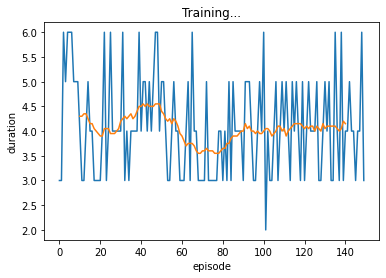

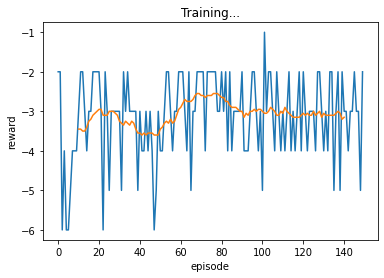

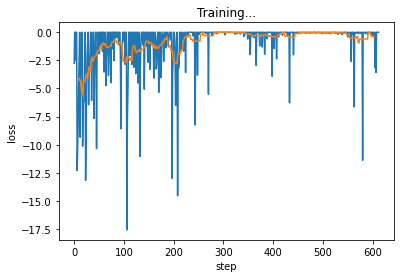

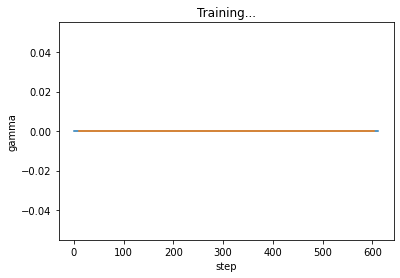

In [152]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(train_interval=64, batch_size=64, clear_memory=True, lr=0.07)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 5 enfix-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 2 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 11 jumpy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 2 adore-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 7 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.15210629591208413  steps 34  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.793535232543945 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.607439994812012 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.0927395820617676 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categori

------guess 1 6 oxide-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 9 light-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 6 fifth-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 2 pitch-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 15 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.31271072120902776  steps 76  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.883704662322998 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.792226552963257 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.9804670810699463 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categoric

------guess 2 2 blush-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 0 shush-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 0
episode 23 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.41725174762601036  steps 109  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.1799075603485107 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.7361350059509277 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 24 gusty======================
------guess 0 6 sonar-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 1 0 whisk-------
reward -1.0 done False action shape <class

------guess 1 2 flaxy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 9 lousy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 6 dryly-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 4 tench-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 5 2 jeely-------
reward -1.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 33 finished.  reward -6.0  eps [0.9, 0.05, 200]  gamma 0.529989385269462  steps 152  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.03895378112793 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -6.913232803344727 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.338648319244385 <class 'torch.Tensor'>
sampler Categorica

------guess 4 2 spire-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 41 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.6034685809250071  steps 186  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.3100098371505737 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -6.180173873901367 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.2900044918060303 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 42 lapel======================
------guess 0 10 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 6 bleat-------
reward -1.0 done False acti

------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 2 towed-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 6 dowel-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 50 finished.  reward -2.0  eps [0.9, 0.05, 200]  gamma 0.668789117758019  steps 222  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.32704535126686096 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 51 scion======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 2 jolts-------
reward -1.0 done False action shape <class 'torch.Tensor'>

------guess 2 2 refly-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 7 ferry-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 58 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.7205690317785927  steps 256  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.6819314360618591 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.7990667819976807 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 59 fanny======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 tidal-------
reward -1.0 done False action shape <class 

------guess 2 8 wacky-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 9 guava-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 66 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.7642539234441365  steps 290  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.1371082067489624 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.6401286125183105 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 67 topic======================
------guess 0 3 aeros-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 1 5 clunk-------
reward -1.0 done False action shape <class 

------guess 3 9 sigma-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 74 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.8021013009163853  steps 325  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.247797727584839 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.5755024552345276 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 75 force======================
------guess 0 5 gules-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 1 2 kythe-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 2 drove-------
reward -1.0 done False action shape <class '

------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 inlet-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 2 teuch-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 5 dampy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 4 2 empty-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 84 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.8395864322248272  steps 367  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.5102574825286865 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.34046053886413574 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.31548482179641724 <class 'torch.Tensor'>
sampler Cate

------guess 1 9 spilt-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 6 still-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 93 finished.  reward -2.0  eps [0.9, 0.05, 200]  gamma 0.8653397043044941  steps 402  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.13788840174674988 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 94 roost======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 roost-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 94 finished.  reward -1.0  eps [0.9, 0.05, 200]  gamma 0.8666795966340506  steps

------guess 2 9 purge-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 there-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 102 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.8852500654027212  steps 434  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.16705501079559326 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.07194336503744125 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 103 rupee======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 rifle-------
reward -1.0 done False action shape <cl

------guess 2 7 snare-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 111 finished.  reward -2.0  eps [0.9, 0.05, 200]  gamma 0.9041527978695013  steps 470  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.10036677122116089 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 112 pinto======================
------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 pilot-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 7 pinto-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 112 finished.  reward -2.0  eps [0.9, 0.05, 200]  gamma 0.9055797768036976  st

------guess 1 9 pilot-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 7 onion-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 7
------guess 3 9 idiom-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 120 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.9199416872132795  steps 506  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.33235830068588257 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.16756857931613922 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 121 bongo======================
------guess 0 9 arose-------
reward -1.0 done False action shape <cl

------guess 0 3 aeros-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 1 9 antic-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 7 again-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 7
------guess 3 7 admin-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 129 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.9334631932849832  steps 543  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -6.37481164932251 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.3090200126171112 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode

------guess 2 8 bring-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 139 finished.  reward -2.0  eps [0.9, 0.05, 200]  gamma 0.9452512093985097  steps 582  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.09080243110656738 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 140 mammy======================
------guess 0 5 yelks-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 1 9 rayon-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 9 gaudy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 catty-------
reward -1.0 done False action shape <class 'torch.Tenso

------guess 0 9 arose-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 1 9 snail-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 7 sauna-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 7
------guess 3 7 sandy-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 148 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.9549507976064422  steps 621  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0809912234544754 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.08676981925964355 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================epis

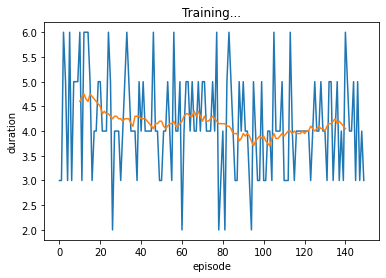

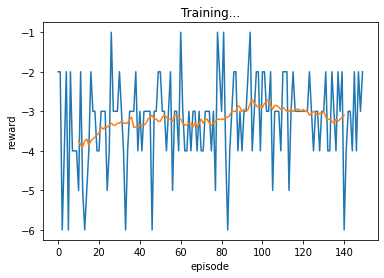

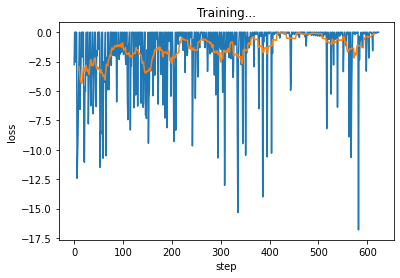

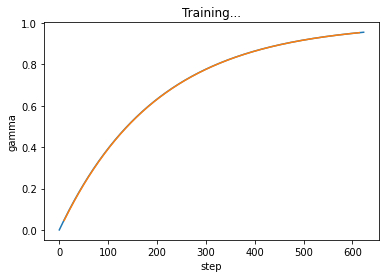

In [153]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(train_interval=64, batch_size=64, clear_memory=True, lr=0.04)
    ))

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=300,
    training=TrainConfig(train_interval=64, batch_size=64, clear_memory=True, lr=1)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 1 retro-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 9 outer-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 11 imply-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 11 winch-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 5 1 otter-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 7 finished.  reward -5.0  eps [0.9, 0.05, 200]  gamma 0.15210629591208413  steps 34  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.65487003326416 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.629429817199707 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.393512725830078 <class 'torch.Tensor'>
sampler Categor

------guess 4 1 whisk-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 13 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.28822967723739035  steps 69  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0051761195063591 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0041364263743162155 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.119061179459095 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 14 cargo======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 lunar-------
reward -1.0 done False ac

------guess 3 1 scaly-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 21 finished.  reward -3.0  eps [0.9, 0.05, 200]  gamma 0.41433070985520626  steps 108  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0017994389636442065 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0003990134864579886 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 22 dusty======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 cavil-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 2 1 urson-------
reward -1.0 done False action shap

------guess 4 6 frown-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 29 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.5180910099097975  steps 147  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.003236131276935339 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0015505601186305285 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.05322837457060814 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 30 flirt======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 flung-------
reward -1.0 done Fals

------guess 2 1 dorad-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 tying-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 nomad-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 36 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.597475775966364  steps 183  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0034113842993974686 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0007325560436584055 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.021440431475639343 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=======

Glog torch.Size([])
pseudo loss -0.7711142301559448 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 44 audio======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 align-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 2 1 aarti-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 duchy-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 audio-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 44 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.6737202053769605  steps 225  memory 0
sampler Categorical(pro

------guess 2 1 arear-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 hunky-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 curve-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 51 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.7261021356685544  steps 260  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.005007569678127766 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0006500346935354173 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.042885471135377884 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=======

------guess 2 1 drony-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 quick-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 11 plumb-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 5 11 shaft-------
reward -1.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 11
episode 58 finished.  reward -6.0  eps [0.9, 0.05, 200]  gamma 0.7746273444605613  steps 299  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.004757819231599569 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.003091098740696907 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0003168750263284892 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.224213186418638e-05 <clas

------guess 3 11 birch-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 flush-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 65 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.812691820518043  steps 336  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0007992258761078119 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.014758307486772537 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -9.775209946383256e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 66 lumen======================
------guess 0 1 esses-------
reward -1.0 done Fa

------guess 2 1 lears-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 wight-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 lapse-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 74 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.8481709405705694  steps 378  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.012103801593184471 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0029523996636271477 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=====

------guess 3 1 aalii-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 4 6 canal-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 11 nymph-------
reward -1.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 11
episode 80 finished.  reward -6.0  eps [0.9, 0.05, 200]  gamma 0.8712650964121957  steps 411  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.031388070434331894 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.695505074574612e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -3.576279254957626e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.015618712641298771 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.00010669800

------guess 2 1 laari-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 1 donor-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 4 6 rowdy-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 88 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.8930078701468855  steps 448  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.0960402712225914 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.5020426872069947e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.152560215217818e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========

------guess 2 1 aurei-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 lynch-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 buyer-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 95 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9097345043902156  steps 482  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.9009176766267046e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.482319491216913e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.232019273331389e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
====

------guess 4 6 piper-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 101 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9234644545760885  steps 515  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.394751961925067e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.2929626690456644e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.4305124977909145e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 102 unzip======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 glory-------
reward -1.0 do

------guess 2 1 talea-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 gumbo-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 bagel-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 109 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9373379952578469  steps 555  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.3053446309641004e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.4717813327442855e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.4305124977909145e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=

------guess 2 1 arear-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 chump-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 farce-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 116 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9479213394240343  steps 592  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.2874630556325428e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.0531199374527205e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.00010729411587817594 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=

------guess 4 6 inlet-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 123 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9565002461706973  steps 628  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.2874630556325428e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.745970338466577e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -7.867844033171423e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 124 vogue======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 wimpy-------
reward -1.0 don

------guess 2 1 taata-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 growl-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 favor-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 11 mucky-------
reward -1.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 11
episode 130 finished.  reward -6.0  eps [0.9, 0.05, 200]  gamma 0.9638471682459536  steps 665  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.1457717593875714e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.00010061390639748424 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -2.7179841708857566e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -0.004637846257537603 <c

------guess 4 6 chump-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 136 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9690381661768231  steps 696  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.2517000868683681e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -5.245277498033829e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -8.463895028398838e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 137 lying======================
------guess 0 1 esses-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 anvil-------
reward -1.0 don

------guess 2 1 saola-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 11 trick-------
reward -1.0 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 6 shoal-------
reward 0.0 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 144 finished.  reward -4.0  eps [0.9, 0.05, 200]  gamma 0.9747770251647728  steps 737  memory 0
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -1.2159372090536635e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -4.529958005150547e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss -9.26299107959494e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([12]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
====

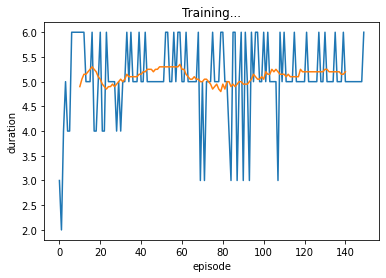

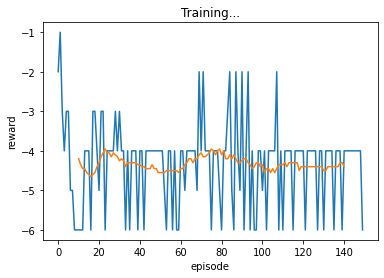

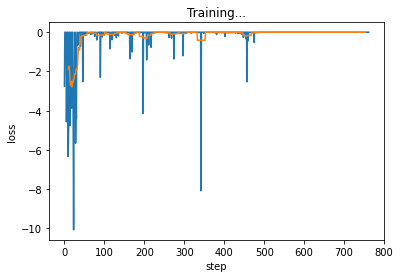

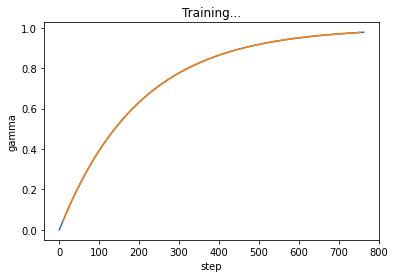

In [157]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(train_interval=64, batch_size=64, clear_memory=True, lr=0.4)
    ))